In [1]:
import torch, torchvision

In [2]:
from PIL import Image
alcf_image = Image.open("ALCF-Staff.jpg")

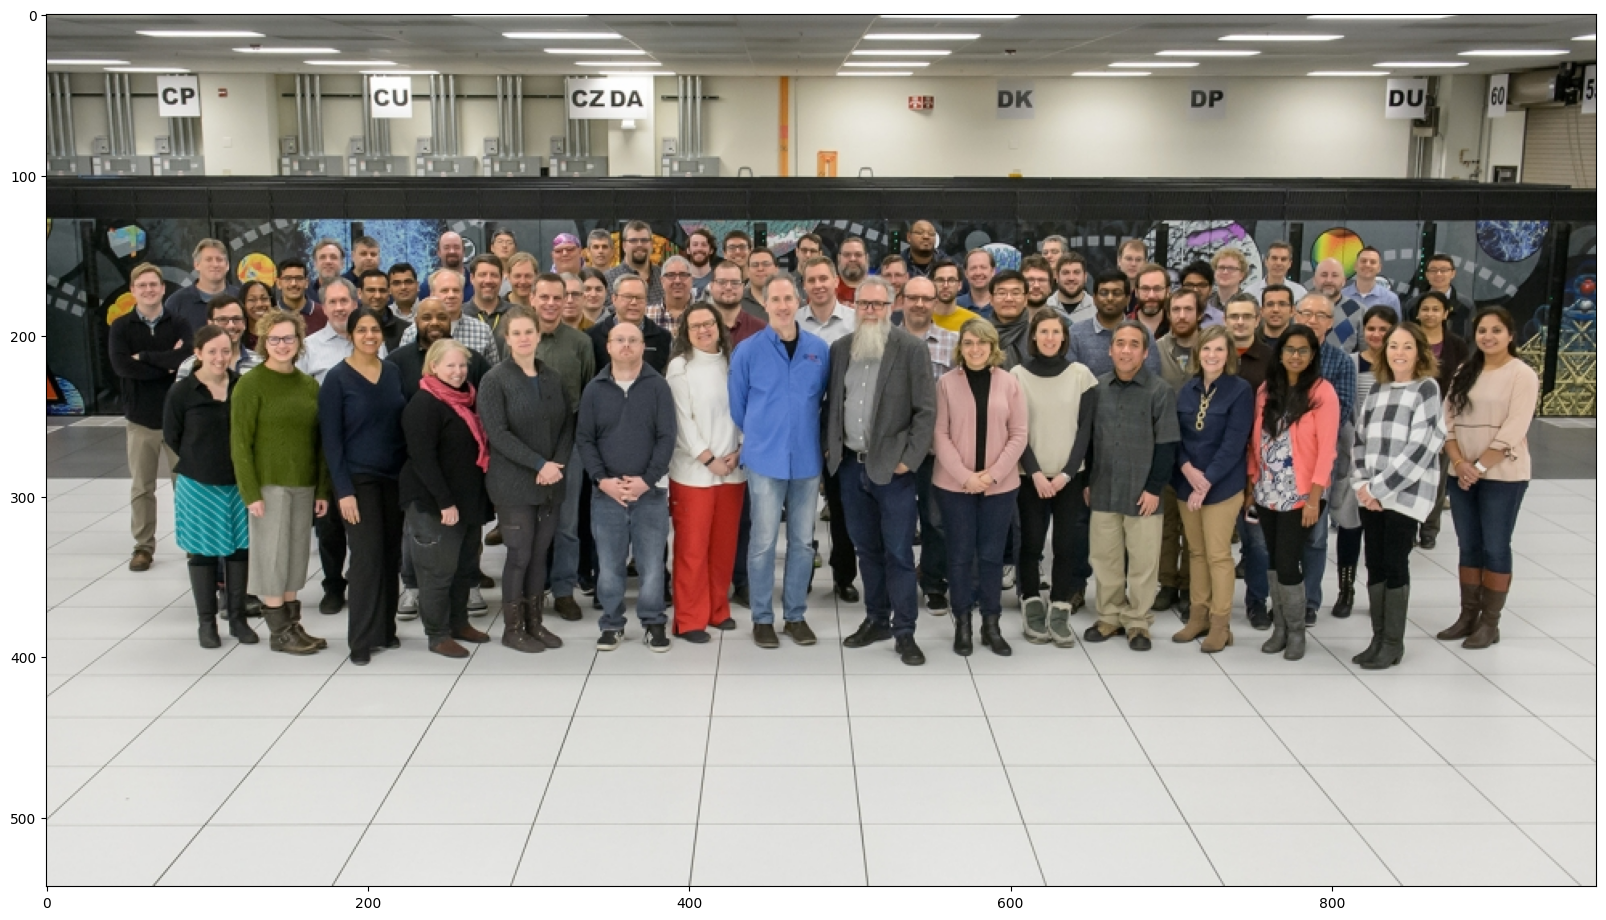

In [3]:
from matplotlib import pyplot as plt
figure = plt.figure(figsize=(20,20))
plt.imshow(alcf_image)
plt.show()

torch.Size([1, 3, 529, 951])
torch.Size([1, 3, 543, 965])


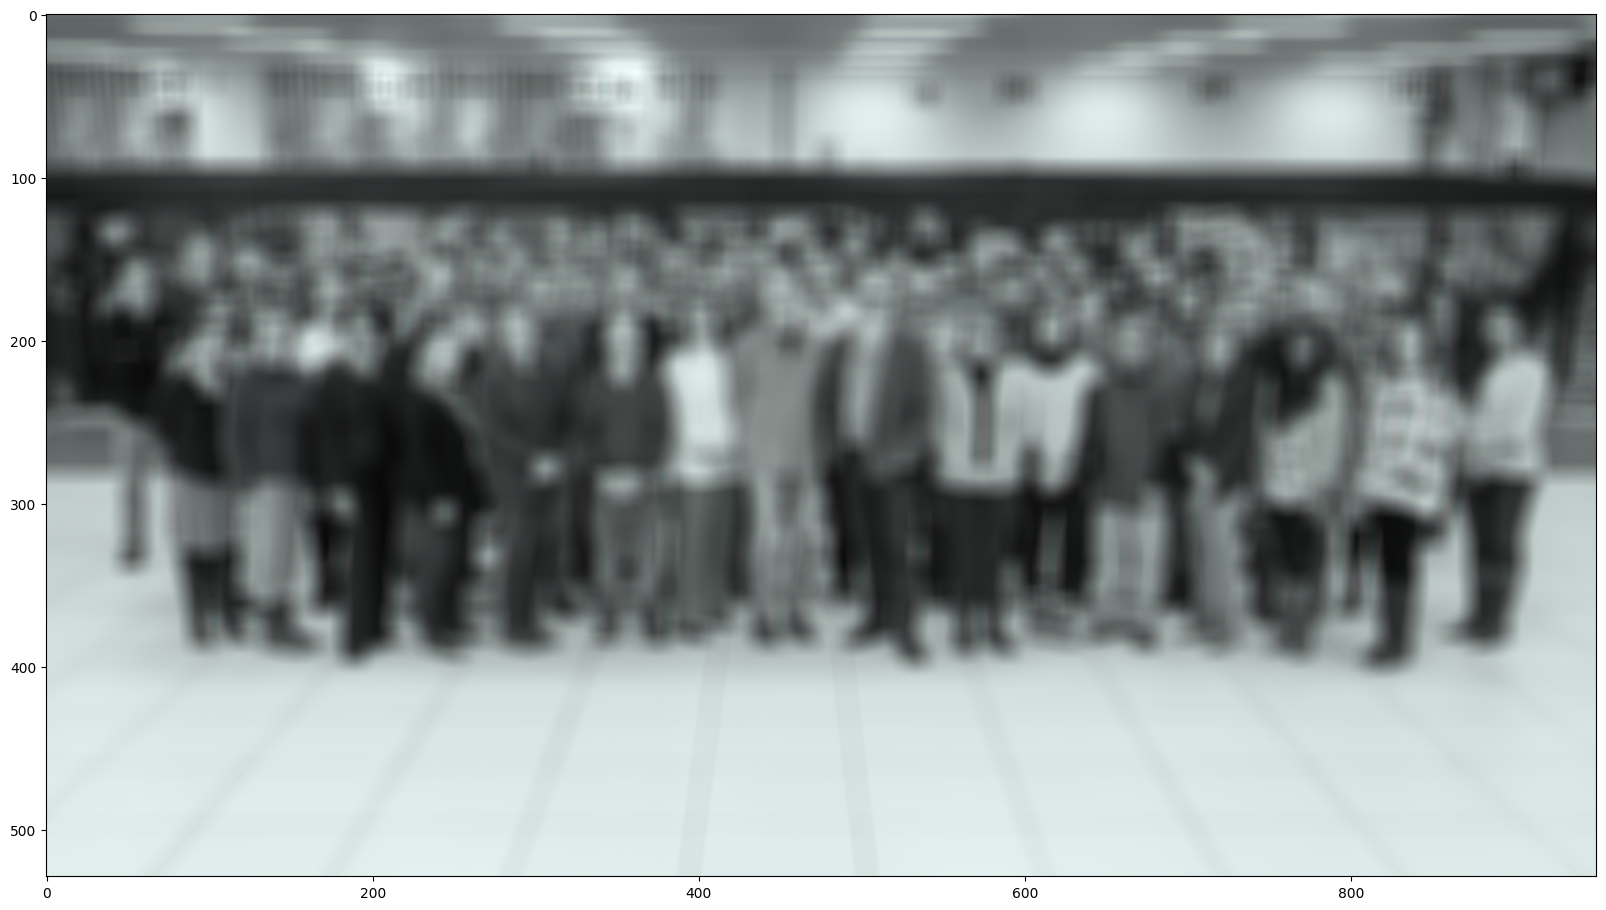

In [4]:
# Let's apply a convolution to the ALCF Staff photo:
alcf_tensor = torchvision.transforms.ToTensor()(alcf_image)

# Reshape the tensor to have a batch size of 1:
alcf_tensor = alcf_tensor.reshape((1,) + alcf_tensor.shape)

# Create a random convolution:
# shape is: (channels_in, channels_out, kernel_x, kernel_y)
conv_random = torch.rand((3,3,15,15))

alcf_rand = torch.nn.functional.conv2d(alcf_tensor, conv_random)
alcf_rand = (1./alcf_rand.max()) * alcf_rand
print(alcf_rand.shape)
alcf_rand = alcf_rand.reshape(alcf_rand.shape[1:])

print(alcf_tensor.shape)

rand_image = alcf_rand.permute((1,2,0)).cpu()

figure = plt.figure(figsize=(20,20))

plt.imshow(rand_image)

torch.Size([1, 3, 543, 965])


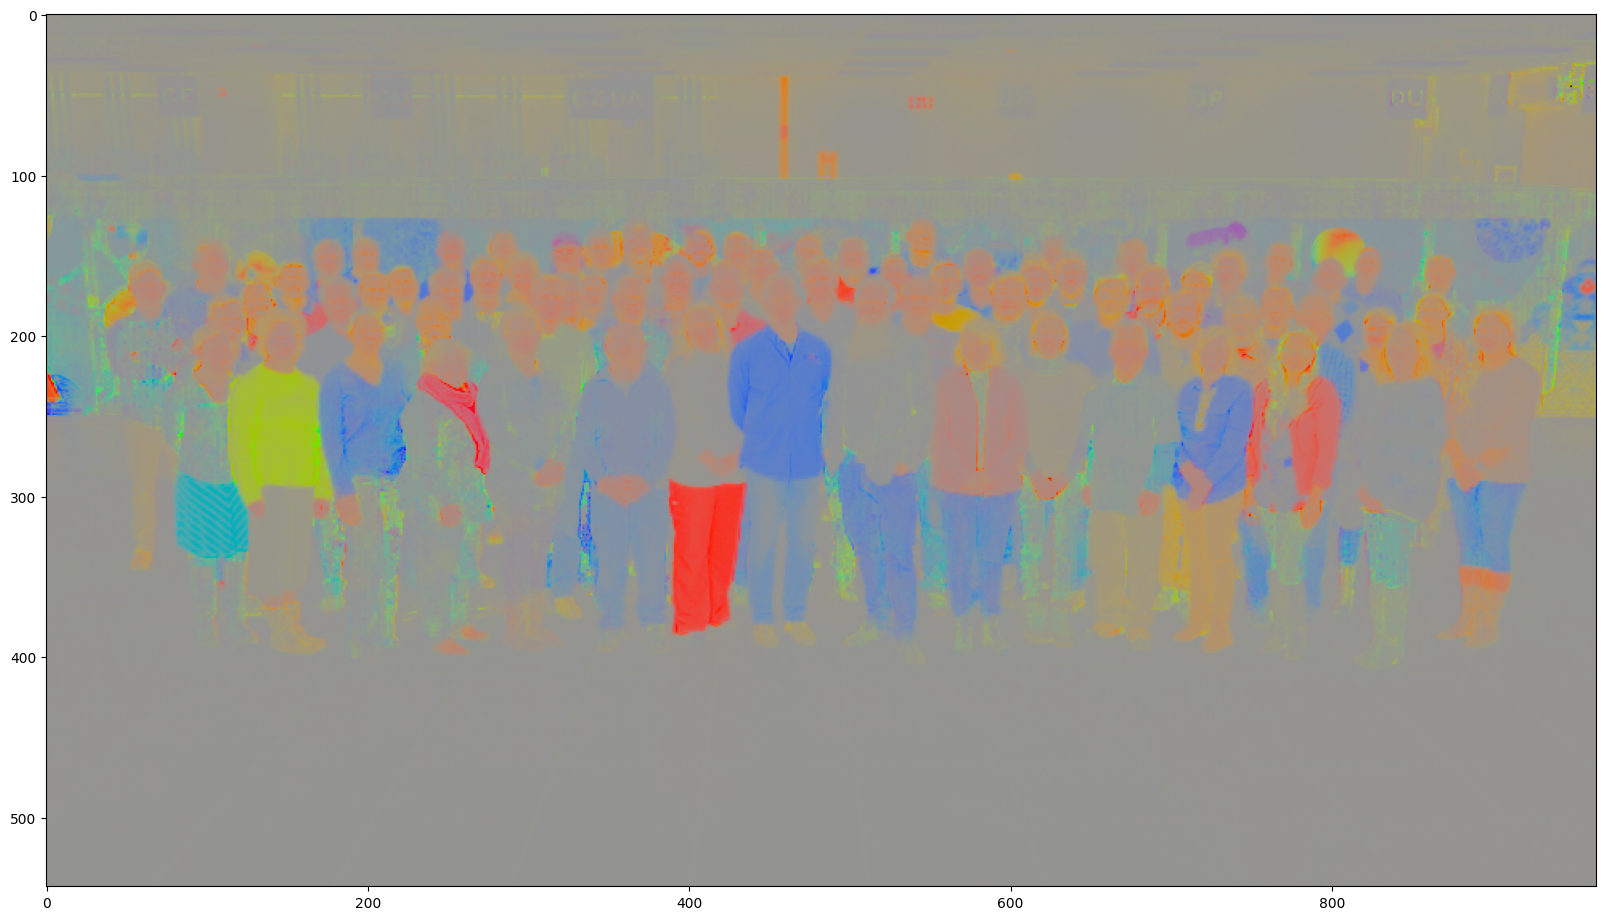

In [5]:
# Let's apply a normalization to the ALCF Staff photo:
alcf_tensor = torchvision.transforms.ToTensor()(alcf_image)

# Reshape the tensor to have a batch size of 1:
alcf_tensor = alcf_tensor.reshape((1,) + alcf_tensor.shape)


alcf_rand = torch.nn.functional.normalize(alcf_tensor)
alcf_rand = alcf_rand.reshape(alcf_rand.shape[1:])

print(alcf_tensor.shape)

rand_image = alcf_rand.permute((1,2,0)).cpu()

figure = plt.figure(figsize=(20,20))

plt.imshow(rand_image)

torch.Size([1, 3, 543, 965])


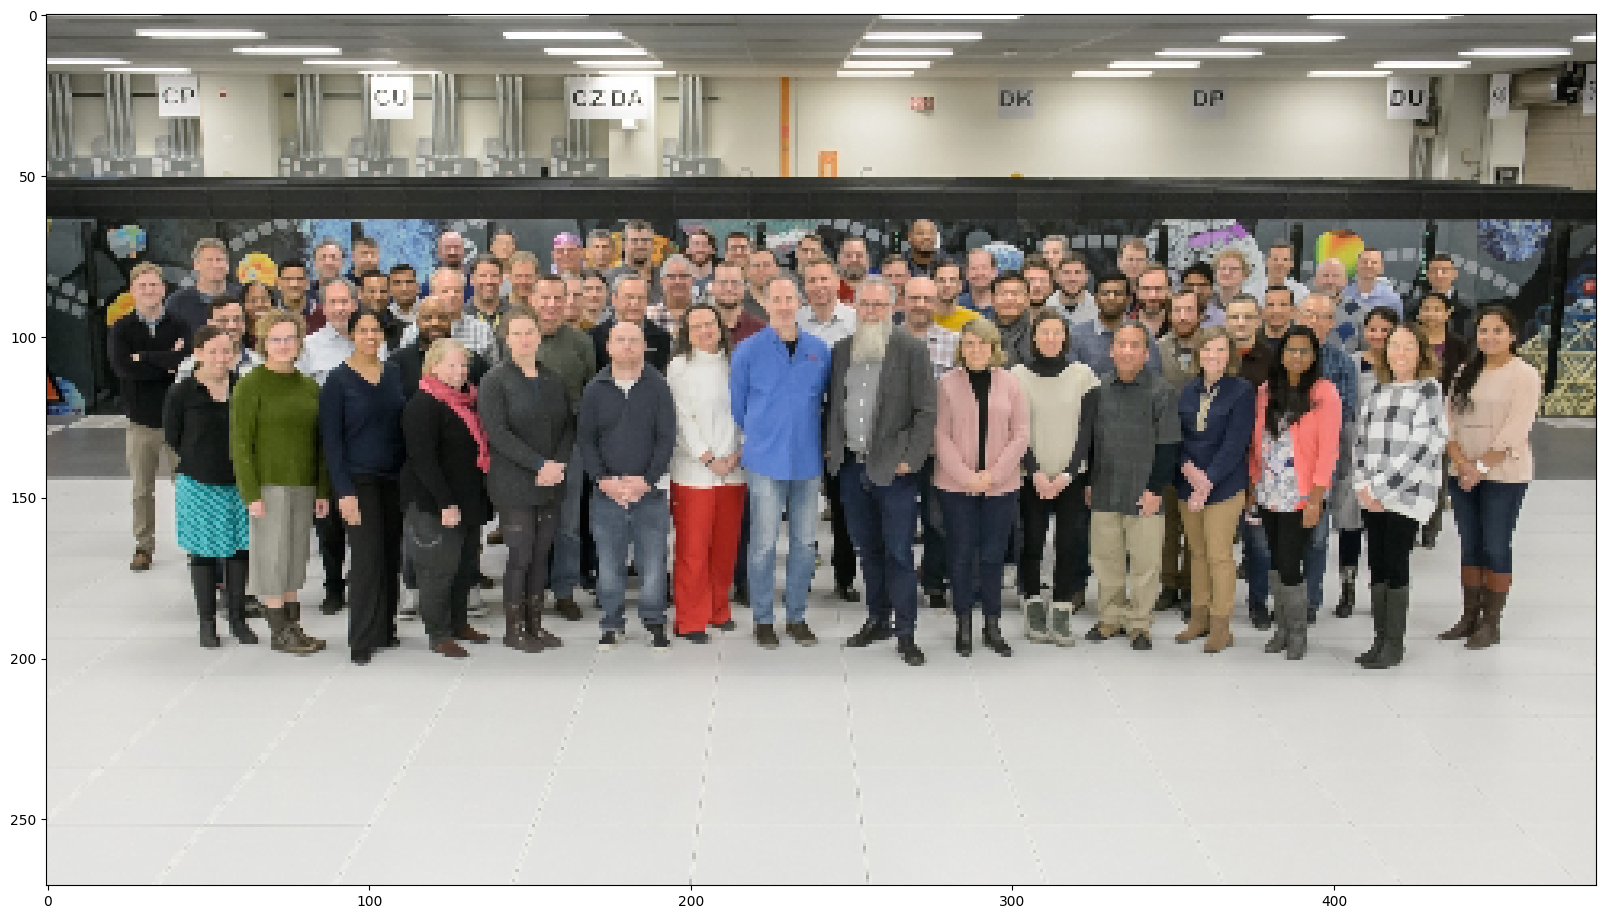

In [6]:
# Let's apply a normalization to the ALCF Staff photo:
alcf_tensor = torchvision.transforms.ToTensor()(alcf_image)

# Reshape the tensor to have a batch size of 1:
alcf_tensor = alcf_tensor.reshape((1,) + alcf_tensor.shape)


alcf_rand = torch.nn.functional.max_pool2d(alcf_tensor, 2)
alcf_rand = alcf_rand.reshape(alcf_rand.shape[1:])

print(alcf_tensor.shape)

rand_image = alcf_rand.permute((1,2,0)).cpu()

figure = plt.figure(figsize=(20,20))

plt.imshow(rand_image)

In [7]:
from torchvision.transforms import v2
training_data = torchvision.datasets.CIFAR10(
    root="/lus/eagle/projects/datasets/CIFAR-10/",
    train=True,
    download=False,
    transform=v2.Compose([
        v2.ToTensor(),
        v2.RandomHorizontalFlip(),
        v2.RandomResizedCrop(size=32, scale=[0.85,1.0], antialias=False),
        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    ])
)

test_data = torchvision.datasets.CIFAR10(
    root="/lus/eagle/projects/datasets/CIFAR-10/",
    train=False,
    download=False,
    transform=torchvision.transforms.ToTensor()
)

training_data, validation_data = torch.utils.data.random_split(training_data, [0.8, 0.2], generator=torch.Generator().manual_seed(55))

batch_size = 128

# The dataloader makes our dataset iterable 
train_dataloader = torch.utils.data.DataLoader(training_data, 
    batch_size=batch_size, 
    pin_memory=True,
    shuffle=True, 
    num_workers=4)
val_dataloader = torch.utils.data.DataLoader(validation_data, 
    batch_size=batch_size, 
    pin_memory=True,
    shuffle=False, 
    num_workers=4)

/soft/applications/conda/2024-04-29/mconda3/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [8]:
from matplotlib import pyplot as plt
%matplotlib inline

/soft/applications/conda/2024-04-29/mconda3/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/soft/applications/conda/2024-04-29/mconda3/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


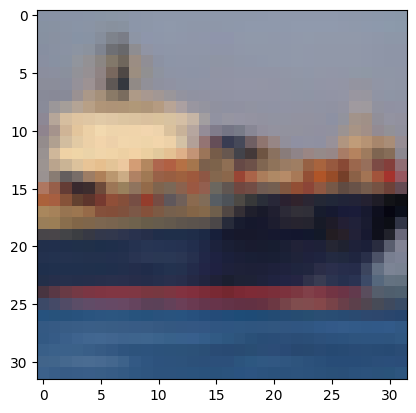

In [9]:
batch, (X, Y) = next(enumerate(train_dataloader))
plt.imshow(X[0].cpu().permute((1,2,0))); plt.show()

In [10]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")


def preprocess(x, y):
    # CIFAR-10 is *color* images so 3 layers!
    return x.view(-1, 3, 32, 32).to(dev), y.to(dev)


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for b in self.dl:
            yield (self.func(*b))


train_dataloader = WrappedDataLoader(train_dataloader, preprocess)
val_dataloader = WrappedDataLoader(val_dataloader, preprocess)

In [11]:
from torch import nn


class Downsampler(nn.Module):

    def __init__(self, in_channels, out_channels, shape, stride=2):
        super(Downsampler, self).__init__()

        self.norm = nn.LayerNorm([in_channels, *shape])

        self.downsample = nn.Conv2d(
            in_channels=in_channels, 
            out_channels=out_channels,
            kernel_size = stride,
            stride = stride,
        )
    
    def forward(self, inputs):


        return self.downsample(self.norm(inputs))
        
        

class ConvNextBlock(nn.Module):
    """This block of operations is loosely based on this paper:

    """


    def __init__(self, in_channels, shape):
        super(ConvNextBlock, self).__init__()

        # Depthwise, seperable convolution with a large number of output filters:
        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=in_channels, 
                                     groups=in_channels,
                                     kernel_size=[7,7],
                                     padding='same' )

        self.norm = nn.LayerNorm([in_channels, *shape])

        # Two more convolutions:
        self.conv2 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=4*in_channels,
                                     kernel_size=1)

        self.conv3 = nn.Conv2d(in_channels=4*in_channels, 
                                     out_channels=in_channels,
                                     kernel_size=1
                                     )


    def forward(self, inputs):
        x = self.conv1(inputs)

        # The normalization layer:
        x = self.norm(x)

        x = self.conv2(x)

        # The non-linear activation layer:
        x = torch.nn.functional.gelu(x)

        x = self.conv3(x)

        # This makes it a residual network:
        return x + inputs
    

class Classifier(nn.Module):


    def __init__(self, n_initial_filters, n_stages, blocks_per_stage):
        super(Classifier, self).__init__()

        # This is a downsampling convolution that will produce patches of output.

        # This is similar to what vision transformers do to tokenize the images.
        self.stem = nn.Conv2d(in_channels=3,
                                    out_channels=n_initial_filters,
                                    kernel_size=1,
                                    stride=1)
        
        current_shape = [32, 32]

        self.norm1 = nn.LayerNorm([n_initial_filters,*current_shape])
        # self.norm1 = WrappedLayerNorm()

        current_n_filters = n_initial_filters
        
        self.layers = nn.Sequential()
        for i, n_blocks in enumerate(range(n_stages)):
            # Add a convnext block series:
            for _ in range(blocks_per_stage):
                self.layers.append(ConvNextBlock(in_channels=current_n_filters, shape=current_shape))
            # Add a downsampling layer:
            if i != n_stages - 1:
                # Skip downsampling if it's the last layer!
                self.layers.append(Downsampler(
                    in_channels=current_n_filters, 
                    out_channels=2*current_n_filters,
                    shape = current_shape,
                    )
                )
                # Double the number of filters:
                current_n_filters = 2*current_n_filters
                # Cut the shape in half:
                current_shape = [ cs // 2 for cs in current_shape]
            


        self.head = nn.Sequential(
            nn.Flatten(),
            nn.LayerNorm(current_n_filters),
            nn.Linear(current_n_filters, 10)
        )
        # self.norm2 = nn.InstanceNorm2d(current_n_filters)
        # # This brings it down to one channel / class
        # self.bottleneck = nn.Conv2d(in_channels=current_n_filters, out_channels=10, 
        #                                   kernel_size=1, stride=1)

    def forward(self, inputs):

        x = self.stem(inputs)
        # Apply a normalization after the initial patching:
        x = self.norm1(x)

        # Apply the main chunk of the network:
        x = self.layers(x)

        # Normalize and readout:
        x = nn.functional.avg_pool2d(x, x.shape[2:])
        x = self.head(x)

        return x



        # x = self.norm2(x)
        # x = self.bottleneck(x)

        # # Average pooling of the remaining spatial dimensions (and reshape) makes this label-like:
        # return nn.functional.avg_pool2d(x, kernel_size=x.shape[-2:]).reshape((-1,10))

In [12]:
model = Classifier(128, 3, 3)

model.cuda()

from torchinfo import summary

print(summary(model, input_size=(batch_size, 3, 32, 32)))

Layer (type:depth-idx)                   Output Shape              Param #
Classifier                               [128, 10]                 --
├─Conv2d: 1-1                            [128, 128, 32, 32]        512
├─LayerNorm: 1-2                         [128, 128, 32, 32]        262,144
├─Sequential: 1-3                        [128, 512, 8, 8]          --
│    └─ConvNextBlock: 2-1                [128, 128, 32, 32]        --
│    │    └─Conv2d: 3-1                  [128, 128, 32, 32]        6,400
│    │    └─LayerNorm: 3-2               [128, 128, 32, 32]        262,144
│    │    └─Conv2d: 3-3                  [128, 512, 32, 32]        66,048
│    │    └─Conv2d: 3-4                  [128, 128, 32, 32]        65,664
│    └─ConvNextBlock: 2-2                [128, 128, 32, 32]        --
│    │    └─Conv2d: 3-5                  [128, 128, 32, 32]        6,400
│    │    └─LayerNorm: 3-6               [128, 128, 32, 32]        262,144
│    │    └─Conv2d: 3-7                  [128, 512, 32,

In [13]:
def evaluate(dataloader, model, loss_fn, val_bar):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing 
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:

            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy 
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            val_bar.update()
            
    loss /= num_batches
    correct /= (size*batch_size)
    
    accuracy = 100*correct
    return accuracy, loss

In [14]:
def train_one_epoch(dataloader, model, loss_fn, optimizer, progress_bar):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # backward pass calculates gradients
        loss.backward()
        
        # take one step with these gradients
        optimizer.step()
        
        # resets the gradients 
        optimizer.zero_grad()      

        progress_bar.update()

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.002, weight_decay=0.01)

In [16]:
from tqdm.notebook import tqdm


epochs = 60
for j in range(epochs):
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Train Epoch {j}") as train_bar:
        train_one_epoch(train_dataloader, model, loss_fn, optimizer, train_bar)
    
    # checking on the training loss and accuracy once per epoch
        
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Validate (train) Epoch {j}") as train_eval:
        acc, loss = evaluate(train_dataloader, model, loss_fn, train_eval)

        print(f"Epoch {j}: training loss: {loss:.3f}, accuracy: {acc:.3f}")
    with tqdm(total=len(val_dataloader), position=0, leave=True, desc=f"Validate Epoch {j}") as val_bar:
    
        acc_val, loss_val = evaluate(val_dataloader, model, loss_fn, val_bar)
        print(f"Epoch {j}: validation loss: {loss_val:.3f}, accuracy: {acc_val:.3f}")

Train Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 0: training loss: 2.342, accuracy: 10.079


Validate Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 0: validation loss: 2.342, accuracy: 9.513


/soft/applications/conda/2024-04-29/mconda3/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /soft/applications/conda/2024-04-29/pytorch/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Train Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1: training loss: 2.097, accuracy: 19.786


Validate Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1: validation loss: 2.099, accuracy: 19.215


Train Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2: training loss: 1.885, accuracy: 29.608


Validate Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2: validation loss: 1.880, accuracy: 29.371


Train Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3: training loss: 1.757, accuracy: 34.732


Validate Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3: validation loss: 1.747, accuracy: 34.237


Train Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4: training loss: 1.638, accuracy: 40.131


Validate Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4: validation loss: 1.629, accuracy: 40.032


Train Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5: training loss: 1.522, accuracy: 44.703


Validate Epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5: validation loss: 1.526, accuracy: 43.602


Train Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6: training loss: 1.463, accuracy: 46.356


Validate Epoch 6:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6: validation loss: 1.473, accuracy: 45.580


Train Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 7: training loss: 1.380, accuracy: 49.965


Validate Epoch 7:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7: validation loss: 1.395, accuracy: 48.616


Train Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 8: training loss: 1.312, accuracy: 51.974


Validate Epoch 8:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8: validation loss: 1.318, accuracy: 51.582


Train Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 9: training loss: 1.271, accuracy: 53.552


Validate Epoch 9:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9: validation loss: 1.296, accuracy: 52.522


Train Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10: training loss: 1.173, accuracy: 57.730


Validate Epoch 10:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10: validation loss: 1.203, accuracy: 56.537


Train Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 11: training loss: 1.100, accuracy: 60.823


Validate Epoch 11:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11: validation loss: 1.150, accuracy: 58.673


Train Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 12: training loss: 1.081, accuracy: 61.452


Validate Epoch 12:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12: validation loss: 1.130, accuracy: 58.703


Train Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 13: training loss: 0.993, accuracy: 64.112


Validate Epoch 13:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13: validation loss: 1.064, accuracy: 61.274


Train Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 14: training loss: 0.988, accuracy: 64.397


Validate Epoch 14:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14: validation loss: 1.061, accuracy: 61.798


Train Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 15: training loss: 0.886, accuracy: 68.962


Validate Epoch 15:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15: validation loss: 0.973, accuracy: 64.814


Train Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 16: training loss: 0.850, accuracy: 69.883


Validate Epoch 16:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16: validation loss: 0.951, accuracy: 65.763


Train Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 17: training loss: 0.799, accuracy: 72.197


Validate Epoch 17:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17: validation loss: 0.913, accuracy: 67.682


Train Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 18: training loss: 0.736, accuracy: 74.017


Validate Epoch 18:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18: validation loss: 0.870, accuracy: 68.938


Train Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 19: training loss: 0.726, accuracy: 74.134


Validate Epoch 19:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19: validation loss: 0.890, accuracy: 68.404


Train Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 20: training loss: 0.669, accuracy: 76.265


Validate Epoch 20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20: validation loss: 0.848, accuracy: 69.561


Train Epoch 21:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 21:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 21: training loss: 0.644, accuracy: 77.256


Validate Epoch 21:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 21: validation loss: 0.835, accuracy: 70.718


Train Epoch 22:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 22:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 22: training loss: 0.610, accuracy: 78.674


Validate Epoch 22:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 22: validation loss: 0.832, accuracy: 70.876


Train Epoch 23:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 23:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 23: training loss: 0.555, accuracy: 80.526


Validate Epoch 23:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 23: validation loss: 0.784, accuracy: 72.478


Train Epoch 24:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 24:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 24: training loss: 0.544, accuracy: 80.489


Validate Epoch 24:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 24: validation loss: 0.791, accuracy: 71.826


Train Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 25: training loss: 0.487, accuracy: 82.760


Validate Epoch 25:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 25: validation loss: 0.743, accuracy: 73.853


Train Epoch 26:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 26:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 26: training loss: 0.449, accuracy: 84.120


Validate Epoch 26:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 26: validation loss: 0.750, accuracy: 74.723


Train Epoch 27:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 27:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 27: training loss: 0.438, accuracy: 84.737


Validate Epoch 27:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 27: validation loss: 0.751, accuracy: 74.575


Train Epoch 28:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 28:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 28: training loss: 0.400, accuracy: 85.995


Validate Epoch 28:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 28: validation loss: 0.757, accuracy: 74.684


Train Epoch 29:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 29:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 29: training loss: 0.361, accuracy: 87.403


Validate Epoch 29:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 29: validation loss: 0.717, accuracy: 75.415


Train Epoch 30:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 30:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 30: training loss: 0.318, accuracy: 89.090


Validate Epoch 30:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 30: validation loss: 0.700, accuracy: 76.246


Train Epoch 31:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 31:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 31: training loss: 0.330, accuracy: 88.309


Validate Epoch 31:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 31: validation loss: 0.748, accuracy: 75.386


Train Epoch 32:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 32:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 32: training loss: 0.277, accuracy: 90.345


Validate Epoch 32:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 32: validation loss: 0.706, accuracy: 76.098


Train Epoch 33:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 33:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 33: training loss: 0.303, accuracy: 89.085


Validate Epoch 33:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 33: validation loss: 0.771, accuracy: 75.574


Train Epoch 34:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 34:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 34: training loss: 0.255, accuracy: 91.099


Validate Epoch 34:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 34: validation loss: 0.759, accuracy: 76.543


Train Epoch 35:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 35:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 35: training loss: 0.222, accuracy: 92.195


Validate Epoch 35:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 35: validation loss: 0.736, accuracy: 76.711


Train Epoch 36:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 36:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 36: training loss: 0.221, accuracy: 92.210


Validate Epoch 36:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 36: validation loss: 0.776, accuracy: 76.988


Train Epoch 37:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 37:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 37: training loss: 0.212, accuracy: 92.340


Validate Epoch 37:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 37: validation loss: 0.777, accuracy: 76.464


Train Epoch 38:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 38:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 38: training loss: 0.200, accuracy: 92.949


Validate Epoch 38:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 38: validation loss: 0.785, accuracy: 76.513


Train Epoch 39:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 39:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 39: training loss: 0.187, accuracy: 93.331


Validate Epoch 39:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 39: validation loss: 0.758, accuracy: 77.265


Train Epoch 40:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 40:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 40: training loss: 0.188, accuracy: 93.346


Validate Epoch 40:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 40: validation loss: 0.822, accuracy: 76.394


Train Epoch 41:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 41:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 41: training loss: 0.159, accuracy: 94.352


Validate Epoch 41:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 41: validation loss: 0.777, accuracy: 77.393


Train Epoch 42:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 42:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 42: training loss: 0.136, accuracy: 95.145


Validate Epoch 42:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 42: validation loss: 0.806, accuracy: 78.066


Train Epoch 43:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 43:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 43: training loss: 0.117, accuracy: 95.857


Validate Epoch 43:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 43: validation loss: 0.769, accuracy: 78.975


Train Epoch 44:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 44:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 44: training loss: 0.177, accuracy: 93.643


Validate Epoch 44:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 44: validation loss: 0.866, accuracy: 76.978


Train Epoch 45:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 45:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 45: training loss: 0.146, accuracy: 94.846


Validate Epoch 45:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 45: validation loss: 0.853, accuracy: 77.205


Train Epoch 46:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 46:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 46: training loss: 0.114, accuracy: 95.964


Validate Epoch 46:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 46: validation loss: 0.789, accuracy: 78.748


Train Epoch 47:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 47:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 47: training loss: 0.093, accuracy: 96.663


Validate Epoch 47:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 47: validation loss: 0.801, accuracy: 78.530


Train Epoch 48:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 48:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 48: training loss: 0.112, accuracy: 95.976


Validate Epoch 48:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 48: validation loss: 0.812, accuracy: 78.303


Train Epoch 49:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 49:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 49: training loss: 0.122, accuracy: 95.697


Validate Epoch 49:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 49: validation loss: 0.845, accuracy: 78.145


Train Epoch 50:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 50: training loss: 0.138, accuracy: 95.158


Validate Epoch 50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 50: validation loss: 0.882, accuracy: 77.472


Train Epoch 51:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 51:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 51: training loss: 0.099, accuracy: 96.476


Validate Epoch 51:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 51: validation loss: 0.821, accuracy: 78.946


Train Epoch 52:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 52:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 52: training loss: 0.092, accuracy: 96.743


Validate Epoch 52:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 52: validation loss: 0.794, accuracy: 78.906


Train Epoch 53:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 53:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 53: training loss: 0.103, accuracy: 96.288


Validate Epoch 53:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 53: validation loss: 0.849, accuracy: 78.530


Train Epoch 54:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 54:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 54: training loss: 0.089, accuracy: 96.785


Validate Epoch 54:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 54: validation loss: 0.845, accuracy: 78.669


Train Epoch 55:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 55:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 55: training loss: 0.097, accuracy: 96.570


Validate Epoch 55:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 55: validation loss: 0.788, accuracy: 79.183


Train Epoch 56:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 56:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 56: training loss: 0.085, accuracy: 96.932


Validate Epoch 56:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 56: validation loss: 0.823, accuracy: 79.430


Train Epoch 57:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 57:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 57: training loss: 0.104, accuracy: 96.234


Validate Epoch 57:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 57: validation loss: 0.815, accuracy: 78.728


Train Epoch 58:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 58:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 58: training loss: 0.080, accuracy: 97.155


Validate Epoch 58:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 58: validation loss: 0.825, accuracy: 79.035


Train Epoch 59:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 59:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 59: training loss: 0.087, accuracy: 96.843


Validate Epoch 59:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 59: validation loss: 0.867, accuracy: 79.411


What I changed as follow:
- epochs: from 30 to 60: allows the model to undergo more iterations of training, potentially capturing more intricate patterns and relationships in the data
- learning rate from 0.001 to 0.002: accelerate the convergence of the optimization process, leading to faster learning and potentially better generalization performance
- model = Classifier(34, 4, 2) to model = Classifier(128, 3, 3)